In [4]:
# this is needed for the "glue" directive used in this notebook
# owslib is needed for the WCS query
!../py/modules/pkginstall.sh "myst-nb owslib"

Installed myst-nb 1.2.0.
Installed owslib 0.33.0.


# Data Retrieval: GBIF & LAND

```{admonition} Summary
:class: hint
In this section, we will retrieve biodiversity data from GBIF/LAND. 

This section covers:

- Understanding the GBIF API
    - Learn how LAND uses the GBIF API to access biodiversity data.
    - Understand key API concepts: endpoints and authentication.
- Using the GBIF Species API
    - Retrieve scientific names from common names using the API.
- Using the GBIF Occurrence API
    - Retrieve occurrence records for a species.
- Mapping Species Data
    - Convert occurrence data into a GeoDataFrame.
    - Reproject data to Web Mercator Projection for visualization.
    - Use Python tools like geopandas and contextily for mapping.
- Advanced API Queries
    - Restrict queries to specific geographic areas (e.g., Saxony).
    - Handle API limitations and optimize large data retrieval.
    - Format spatial queries using bounding boxes and WKT polygons.
```

## GBIF API Reference

```{figure} https://techdocs.gbif.org/en/_images/td-bg-02.png
:name: gbif-graphic
:figclass: fig-no-shadow

GBIF API Reference (https://techdocs.gbif.org/en/openapi/).
```

LAND uses the [GBIF Application Programming Interface (API)](https://techdocs.gbif.org/en/openapi/) to provide standardized ways to access biodiversity data. 

Retrieving data from APIs requires a specific syntax, which varies for each service. Here are two key concepts:

- **Endpoint**: APIs commonly provide URLs (endpoints) that return structured data (e.g., in JSON format). The base URL for the GBIF API is [https://api.gbif.org/](https://api.gbif.org/). 
- **Authentication**: Some APIs require authentication (such as API keys or OAuth tokens), while others - like GBIF- allow limited access without authentication.

```{dropdown} How do I know how to work with GBIF API?
Good APIs have a documentation that explains how to use the specific API. It provides details on available endpoints, request methods (e.g., GET, POST), required parameters, and response formats (e.g., JSON, XML), often including code examples and testing tools. Good documentation helps developers to interact with the API efficiently.

The [GBIF API Reference documentation](https://techdocs.gbif.org/en/openapi/) is well-structured and divided into several sections. GGBIF uses a RESTful API, which can be accessed through structured URLs. A great feature of this documentation is that it’s built using [Swagger](https://swagger.io/), an interactive API framework. Swagger-based API pages allow users to test API queries directly in the browser, making it easier to understand how they work.
```

## Using the GBIF Species API

### Finding a species' scientific name

Let’s say we only have a species' common name — such as `English Sparrow`, which is also known as `House Sparrow` - and want to find its scientific name. The scientific name is essential for accurate data retrieval, as common names vary across languages and regions.

We can search for the scientific name manually on Google or the [GBIF species search](https://www.gbif.org/species/search?q=english%20sparrow), but a more efficient approach is to use the **GBIF Species API**.

```{admonition} Using the GBIF Species API in the browser
:class: dropdown, hint

The [GBIF Species API section](https://techdocs.gbif.org/en/openapi/v1/species#/Searching%20names/searchNames) allows to try the API directly in a web browser.

1. Go to <a href="https://techdocs.gbif.org/en/openapi/v1/species#/Searching%20names/searchNames">https://techdocs.gbif.org/en/openapi/v1/species#/Searching%20names/searchNames</a> and use the general species search for "English Sparrow".
2. Enter `English Sparrow` in the parameter field labeled `q`, which has the explaination: *"The value for this parameter can be a simple word or a phrase. Wildcards are not supported"* (Hint: The parameter field is located in the middle of the webpage). 

We also specify a dataset to check this taxon. In this case, we use the base [GBIF Backbone Taxonomy](https://www.gbif.org/dataset/d7dddbf4-2cf0-4f39-9b2a-bb099caae36c).

```

### Retrieving GBIF Species API in Python
We can also query the API directly using Python:

In [5]:
import requests

# Define search parameters
search_name = "English Sparrow"
dataset_key = "d7dddbf4-2cf0-4f39-9b2a-bb099caae36c"

# Construct API URL
query_url = f'https://api.gbif.org/v1/species/search?q={search_name}&datasetKey={dataset_key}'

# Send request to the API
json_text = None
response = requests.get(url=query_url)

**Understanding the code**

- `f'{}'`: This is an f-string, [a convenient python convention](https://realpython.com/python-f-strings/) to concat strings and variables.
- `requests.get()`: Sends a GET request to retrieve data from the API.
- The data can be found in `response.text`, assuming the API responds successfully.

**Parsing JSON data**

The API returns a JSON object containing multiple species matching our search query. We parse it using the `json` module:

In [6]:
import json

# Load JSON response
json_data = json.loads(response.text)
# Print first 1000 characters
print(json.dumps(json_data, indent=2)[0:1000])

{
  "offset": 0,
  "limit": 20,
  "endOfRecords": true,
  "count": 1,
  "results": [
    {
      "key": 5231190,
      "nameKey": 8290258,
      "datasetKey": "d7dddbf4-2cf0-4f39-9b2a-bb099caae36c",
      "constituentKey": "7ddf754f-d193-4cc9-b351-99906754a03b",
      "nubKey": 5231190,
      "parentKey": 2492321,
      "parent": "Passer",
      "basionymKey": 8933000,
      "basionym": "Fringilla domestica Linnaeus, 1758",
      "kingdom": "Animalia",
      "phylum": "Chordata",
      "order": "Passeriformes",
      "family": "Passeridae",
      "genus": "Passer",
      "species": "Passer domesticus",
      "kingdomKey": 1,
      "phylumKey": 44,
      "classKey": 212,
      "orderKey": 729,
      "familyKey": 5264,
      "genusKey": 2492321,
      "speciesKey": 5231190,
      "scientificName": "Passer domesticus (Linnaeus, 1758)",
      "canonicalName": "Passer domesticus",
      "authorship": "(Linnaeus, 1758) ",
      "publishedIn": "Syst. Nat. ed. 10 p. 183",
      "nameType": "SC

The answer, `Passer domesticus`, is hidden in the nested JSON response. 
(content:references:nub-id)=

**Extracting the scientific name**

To extract only the scientific name, we navigate through the JSON structure. Below, we walk the json path from the `"results"`, which is a list, access the first entry by using `[0]` and the access its key of the name `scientificName`.

In [7]:
scientific_name = json_data["results"][0]["scientificName"]
print(scientific_name)

Passer domesticus (Linnaeus, 1758)


**Getting the taxon ID**

Each species in GBIF has a unique taxon ID. The taxon ID uniquely identifies a species in the GBIF database, ensuring precise queries. This is neccessary for retrieving occurrence data.
(content:references:passer-id)=

In [8]:
taxon_id = json_data["results"][0]["taxonID"]
print(taxon_id)

gbif:5231190


(content:references:admonition)=
```{admonition} Try it with another species
:class: dropdown, attention
You can modify the script to search for any species by replacing `English Sparrow` with another common name.
```

## Using the GBIF Occurrence API

### Finding species observations

Now, we want to find species observations of `Passer domesticus` (English Sparrow). 

Species observations can be previewed in the [LAND Occurrence Search](https://land.gbif.de/occurrence/search/) geo viewer. To see results for `Passer domesticus`, use the search function or click [here](https://land.gbif.de/occurrence/search/?taxonKey=5231190&view=MAP). Another option is to use the unique taxon ID `5231190` instead of the scientific name.

Since LAND relies on the GBIF API, we can efficiently access the data programmatically using the GBIF Occurrence API.

```{admonition} Using the GBIF Occurrence API in the browser
:class: dropdown, hint

The [GBIF Occurrence API](https://techdocs.gbif.org/en/openapi/v1/occurrence#/Searching%20occurrences/searchOccurrence) allows users to test queries directly in a web browser.
```

 ```{admonition} Recommended citation
:class: attention

There are several possibilities for citing the data used. The appropriate citation depends on how the GBIF data was downloaded and the choice of GBIF dataset(s), which determine how we need to cite the authors of these datasets. Please refer to the [citation guidelines](https://www.gbif.org/citation-guidelines) to find the appropriate citation format for your project.

Since we used only a species dataset (the base taxonomy), we used the default citation from the `passer domesticus` species page:

> Passer domesticus (Linnaeus, 1758) in GBIF Secretariat (2023). GBIF Backbone Taxonomy. Checklist dataset https://doi.org/10.15468/39omei accessed via GBIF.org on 2025-03-06.
```

### Retrieving GBIF Occurrence API in Python

**Load dependencies**

In [9]:
# Standard library imports
import json
import os
import sys
import io
from pathlib import Path

# Third-party imports
import requests
import geopandas as gp
import pandas as pd
import geoviews as gv
import holoviews as hv
import matplotlib.pyplot as plt
import shapely
from cartopy import crs as ccrs
from shapely.geometry import Point, Polygon
from shapely.wkt import dumps
from IPython.display import display, Markdown
import contextily as cx

**Load helper tools**

To simplify the workflow, we use a set of helper tools stored in `py/modules/tools.py`. The following code snippet loads these tools to improve reusability.

In [10]:
module_path = str(Path.cwd().parents[0] / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools

In [11]:
tools.display_file(Path.cwd().parents[0] / 'py' / 'modules' / 'tools.py')

<details style='cursor: pointer;'><summary>Have a look at <code>tools.py</code></summary>

```Python

""" A number of helper tools to reduce code in the training materials

    Source: https://gitlab.hrz.tu-chemnitz.de/s7398234--tu-dresden.de/base_modules/
"""
import os
import io
import csv
import numpy as np
import warnings
import requests
import pandas as pd
import geopandas as gp
import zipfile
import shutil
import pkg_resources
import platform
import fnmatch
import matplotlib.pyplot as plt
import base64
import geoviews as gv
import textwrap
import mapclassify as mc
from PIL import Image
from cartopy import crs
from itertools import islice
from pathlib import Path
from collections import namedtuple
from IPython.display import clear_output
from typing import List, Optional, Dict, Tuple
from IPython.display import HTML, display
from IPython.display import Markdown as md
from datetime import date
from adjustText import adjust_text
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
from pyproj import Transformer
from urllib.parse import urlparse

OUTPUT = Path.cwd().parents[0] / "out"

class DbConn(object):

    def __init__(self, db_conn):
        self.db_conn = db_conn

    def query(self, sql_query: str) -> pd.DataFrame:
        """Execute Calculation SQL Query with pandas"""
        with warnings.catch_warnings():
            # ignore warning for non-SQLAlchemy Connecton
            # see github.com/pandas-dev/pandas/issues/45660
            warnings.simplefilter('ignore', UserWarning)
            # create pandas DataFrame from database query
            df = pd.read_sql_query(sql_query, self.db_conn)
        return df

    def close(self):
        self.db_conn.close()

def classify_data(values: np.ndarray, scheme: str):
    """Classify data (value series) and return classes,
       bounds, and colormap
       
    Args:
        grid: A geopandas geodataframe with metric column to classify
        metric: The metric column to classify values
        scheme: The classification scheme to use.
        mask_nonsignificant: If True, removes non-significant values
            before classifying
        mask_negative: Only consider positive values.
        mask_positive: Only consider negative values.
        cmap_name: The colormap to use.
        return_cmap: if False, returns list instead of mpl.ListedColormap
        store_classes: Update classes in original grid (_cat column). If
            not set, no modifications will be made to grid.
        
    Adapted from:
        https://stackoverflow.com/a/58160985/4556479
    See available colormaps:
        http://holoviews.org/user_guide/Colormaps.html
    See available classification schemes:
        https://pysal.org/mapclassify/api.html
        
    Notes: some classification schemes (e.g. HeadTailBreaks)
        do not support specifying the number of classes returned
        construct optional kwargs with k == number of classes
    """
    optional_kwargs = {"k":7}
    if scheme == "HeadTailBreaks":
        optional_kwargs = {}
    scheme_breaks = mc.classify(
        y=values, scheme=scheme, **optional_kwargs)
    return scheme_breaks

def display_file(file_path: Path, formatting: str = 'Python', summary_txt: str = 'Have a look at '):
    """Load a file and display as Markdown formatted details-summary code-block"""
    txt = f"<details style='cursor: pointer;'><summary>{summary_txt}<code>{file_path.name}</code></summary>\n\n```{formatting}\n\n"
    txt += open(file_path, 'r').read() 
    txt += "\n\n```\n\n</details>"
    display(md(txt))

def print_link(url: str, hashtag: str):
    """Format HTML link with hashtag"""
    return f"""
        <div class="alert alert-warning" role="alert" style="color: black;">
            <strong>Open the following link in a new browser tab and have a look at the content:</strong>
            <br>
            <a href="{url}">Instagram: {hashtag} feed (json)</a>
        </div>
        """

FileStat = namedtuple('File_stat', 'name, size, records')

def get_file_stats(name: str, file: Path) -> Tuple[str, str, str]:
    """Get number of records and size of CSV file"""
    num_lines = f'{sum(1 for line in open(file)):,}'
    size = file.stat().st_size
    size_gb = size/(1024*1024*1024)
    size_format = f'{size_gb:.2f} GB'
    size_mb = None
    if size_gb < 1:
        size_mb = size/(1024*1024)
        size_format = f'{size_mb:.2f} MB'
    if size_mb and size_mb < 1:
        size_kb = size/(1024)
        size_format = f'{size_kb:.2f} KB'
    return FileStat(name, size_format, num_lines)

def display_file_stats(filelist: Dict[str, Path]):
    """Display CSV """
    df = pd.DataFrame(
        data=[
            get_file_stats(name, file) for name, file in filelist.items() if file.exists()
            ]).transpose()
    header = df.iloc[0]
    df = df[1:]
    df.columns = header
    display(df.style.background_gradient(cmap='viridis'))

def get_sample_url(use_base: bool = None):
    """Retrieve sample json url from .env"""
    if use_base is None:
        use_base = True
    try:
        from dotenv import load_dotenv
    except ImportError:
        load_dotenv = None 

    if load_dotenv:
        load_dotenv(Path.cwd().parents[0] / '.env', override=True)
    else:
        print("dotenv package not found, could not load .env")
    SAMPLE_URL = os.getenv("SAMPLE_URL")
    if SAMPLE_URL is None:
        raise ValueError(
            f"Environment file "
            f"{Path.cwd().parents[0] / '.env'} not found")
    if use_base:
        SAMPLE_URL = f'{BASE_URL}{SAMPLE_URL}'
    return SAMPLE_URL

def return_total(headers: Dict[str, str]):
    """Return total length from requests header"""
    if not headers:
        return 
    total_length = headers.get('content-length')
    if not total_length:
        return
    try:
        total_length = int(total_length)
    except:
        total_length = None
    return total_length
    
def stream_progress(total_length: int, loaded: int):
    """Stream progress report"""
    clear_output(wait=True)            
    perc_str = ""
    if total_length:
        total = total_length/1000000
        perc = loaded/(total/100)
        perc_str = f"of {total:.2f} ({perc:.0f}%)"
    print(
        f"Loaded {loaded:.2f} MB "
        f"{perc_str}..")

def stream_progress_basic(total: int, loaded: int):
    """Stream progress report"""
    clear_output(wait=True)            
    perc_str = ""
    if total:
        perc = loaded/(total/100)
        perc_str = f"of {total:.0f} ({perc:.0f}%)"
    print(
        f"Processed {loaded:.0f} "
        f"{perc_str}..")

def get_stream_file(url: str, path: Path):
    """Download file from url and save to path"""
    chunk_size = 8192
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_length = return_total(r.headers)
        with open(path, 'wb') as f:
            for ix, chunk in enumerate(r.iter_content(chunk_size=chunk_size)): 
                f.write(chunk)
                loaded = (ix*chunk_size)/1000000
                if (ix % 100 == 0):
                    stream_progress(
                        total_length, loaded)
            stream_progress(
                total_length, loaded)
                        
def get_stream_bytes(url: str):
    """Stream file from url to bytes object (in-memory)"""
    chunk_size = 8192
    content = bytes()
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_length = return_total(r.headers)
        for ix, chunk in enumerate(r.iter_content(
                chunk_size=chunk_size)): 
            content += bytes(chunk)
            loaded = (ix*chunk_size)/1000000
            if (ix % 100 == 0):
                stream_progress(
                    total_length, loaded)
    stream_progress(
        total_length, loaded)
    return content
                        
def highlight_row(s, color):
    return f'background-color: {color}'

def display_header_stats(
        df: pd.DataFrame, metric_cols: List[str], base_cols: List[str]):
    """Display header stats for CSV files"""
    pd.options.mode.chained_assignment = None
    # bg color metric cols
    for col in metric_cols:
        df.loc[df.index, col] = df[col].str[:25]
    styler = df.style
    styler.applymap(
        lambda x: highlight_row(x, color='#FFF8DC'), 
        subset=pd.IndexSlice[:, metric_cols])
    # bg color base cols
    styler.applymap(
        lambda x: highlight_row(x, color='#8FBC8F'), 
        subset=pd.IndexSlice[:, base_cols])
    # bg color index cols (multi-index)
    css = []
    for ix, __ in enumerate(df.index.names):
        idx = df.index.get_level_values(ix)
        css.extend([{
            'selector': f'.row{i}.level{ix}',
            'props': [('background-color', '#8FBC8F')]}
                for i,v in enumerate(idx)])
    styler.set_table_styles(css)
    display(styler)

def get_folder_size(folder: Path):
    """Return size of all files in folder in MegaBytes"""
    if not folder.exists():
        raise Warning(
            f"Folder {folder} does not exist")
        return
    size_mb = 0
    for file in folder.glob('*'):
        size_mb += file.stat().st_size / (1024*1024)
    return size_mb

def get_zip_extract(
    output_path: Path, 
    uri: str = None, filename: str = None, uri_filename: str = None,
    create_path: bool = True, skip_exists: bool = True,
    report: bool = True, filter_files: List[str] = None,
    write_intermediate: bool = None):
    """Get Zip file and extract to output_path.
    Create Path if not exists."""
    if uri is None or filename is None:
        if uri_filename is None:
            raise ValueError("Either specify uri and filename or the complete url (uri_filename)")
        url_prs = urlparse(uri_filename)
        filename = os.path.basename(url_prs.path)
        uri = f"{url_prs.scheme}://{url_prs.netloc}{os.path.dirname(url_prs.path)}/"
    if write_intermediate is None:
        write_intermediate = False
    if create_path:
        output_path.mkdir(
            exist_ok=True)
    if skip_exists and Path(
        output_path / Path(filename).with_suffix('')).exists():
        # check if folder exists 
        # remove .zip suffix from filename first
        if report:
            print("File already exists.. skipping download..")
        return
    if write_intermediate:
        out_file = output_path / filename
        get_stream_file(f'{uri}{filename}', out_file)
        z = zipfile.ZipFile(out_file)
    else:
        content = get_stream_bytes(
            f'{uri}{filename}')
        z = zipfile.ZipFile(io.BytesIO(content))
    print("Extracting zip..")
    if filter_files:
        file_names = z.namelist()
        for filename in file_names:
            if filename in filter_files:
                z.extract(filename, output_path)
    else:
        z.extractall(output_path)
    if write_intermediate:
        if out_file.is_file():
            out_file.unlink()
    if report:
        raw_size_mb = get_folder_size(output_path)
        print(
            f"Retrieved {filename}, "
            f"extracted size: {raw_size_mb:.2f} MB")

def zip_dir(path: Path, zip_file_path: Path):
    """Zip all contents of path to zip_file. Will not recurse subfolders."""
    files_to_zip = [
        file for file in path.glob('*') if file.is_file()]
    with zipfile.ZipFile(
        zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zip_f:
        for file in files_to_zip:
            zip_f.write(file, file.name)

def drop_cols_except(
        df: pd.DataFrame, columns_keep: List[str], inplace: bool = None) -> Optional[pd.DataFrame]:
    """Drop all columns from DataFrame except those specified in columns_keep
    """
    cols_to_drop = df.columns.difference(columns_keep)
    if inplace is None:
        # by default, drop with inplace=True
        df.drop(
            cols_to_drop, axis=1, inplace=True)
        return
    return df.drop(cols_to_drop, axis=1, inplace=False)
        
    
def clean_folder(path: Path):
    """Remove folder, warn if recursive"""
    if not path.is_dir():
        print(f"{path} is not a directory")
        return
    raw_size_mb = get_folder_size(path)
    contents = [content for content in path.glob('*')]
    answer = input(
        f"Removing {path.stem} with "
        f"{len(contents)} files / {raw_size_mb:.0f} MB ? "
        f"Type 'y' or 'yes'")
    if answer not in ["y", "yes"]:
        print("Cancel.")
        return
    for content in contents:
        if content.is_file():
            content.unlink()
            continue
        try:
            content.rmdir()
        except:
            raise Warning(
                f"{content.name} contains subdirs. "
                f"Cancelling operation..")
            return
    path.rmdir()

def clean_folders(paths: List[Path]):
    """Clean list of folders (depth: 2)"""
    for path in paths:
        clean_folder(path)
    print(
        "Done. Thank you. "
        "Do not forget to shut down your notebook server "
        "(File > Shut Down), once you are finished with "
        "the last notebook.")

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def package_report(root_packages: List[str], python_version = True):
    """Report package versions for root_packages entries"""
    root_packages.sort(reverse=True)
    root_packages_list = []
    if python_version:
        pyv = platform.python_version()
        root_packages_list.append(["python", pyv])
    for m in pkg_resources.working_set:
        if m.project_name.lower() in root_packages:
            root_packages_list.append([m.project_name, m.version])
    html_tables = ''
    for chunk in chunks(root_packages_list, 10):
        # get table HTML
        html_tables += pd.DataFrame(
                    chunk,
                    columns=["package", "version"]
                ).set_index("package").transpose().to_html()
    display(HTML(
        f'''
        <details><summary style="cursor: pointer;">List of package versions used in this notebook</summary>
        {html_tables}
        </details>
        '''
        ))

def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=1000, ignore_files_folders=None, ignore_match=None):
    """Given a directory Path object print a visual tree structure
    Source: https://stackoverflow.com/a/59109706/4556479
    """
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    space =  '    '
    branch = '│   '
    # pointers:
    tee =    '├── '
    last =   '└── '
    print_list = []
    always_ignore_files_folders = [".git", ".ipynb_checkpoints", "__pycache__", "__init__.py", "*.bak"]
    if ignore_files_folders is None:
        ignore_files_folders = always_ignore_files_folders
    else:
        ignore_files_folders += always_ignore_files_folders
    if ignore_match is None:
        ignore_match = ["_*", "*.pyc", "*.bak"] 
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if
                        d.name not in ignore_files_folders]
        else: 
            contents = [d for d in dir_path.iterdir()
                        if d.name not in ignore_files_folders and
                        not any(fnmatch.fnmatch(d, pat) for pat in ignore_match)]
        # print(f'{contents[1].name})
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print_list.append(".")
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print_list.append(line)
    if next(iterator, None):
        print_list.append(f'... length_limit, {length_limit}, reached, counted:')
    print_list.append(f'\n{directories} directories' + (f', {files} files' if files else ''))
    br = "<br>"
    return HTML(f"""
        <div>
            <details><summary style='cursor: pointer;'>Directory file tree</summary>
            <pre><code>{"<br>".join(print_list)}
            </pre></code>
            </details>
        </div>      
        """)

def record_preview_hll(file: Path, num: int = 0):
    """Get record preview for hll data"""
    with open(file, 'r', encoding="utf-8") as file_handle:
        post_reader = csv.DictReader(
                    file_handle,
                    delimiter=',',
                    quotechar='"',
                    quoting=csv.QUOTE_MINIMAL)
        for ix, hll_record in enumerate(post_reader):
            hll_record = get_hll_record(hll_record, strip=True)
            # convert to df for display
            display(pd.DataFrame(data=[hll_record]).rename_axis(
                f"Record {ix}", axis=1).transpose().style.background_gradient(cmap='viridis'))
            # stop iteration after x records
            if ix >= num:
                break

HllRecord = namedtuple('Hll_record', 'latitude, longitude, user_hll, post_hll, date_hll')
HllOriginRecord = namedtuple('HllOrigin_record', 'origin_id, latitude, longitude, user_hll, post_hll, date_hll')

def strip_item(item, strip: bool):
    if item is None:
        return
    if not strip:
        return item
    if len(item) > 120:
        item = item[:120] + '..'
    return item

def get_hll_record(record, strip: bool = None):
    """Concatenate topic info from post columns"""

    origin_id = record.get('origin_id')
    latitude = record.get('latitude')
    longitude = record.get('longitude')
    cols = ['user_hll', 'post_hll', 'date_hll']
    col_vals = []
    for col in cols:
        col_val = record.get('user_hll')
        col_vals.append(strip_item(record.get(col), strip))
    if not origin_id is None:
        return HllOriginRecord(origin_id, latitude, longitude, *col_vals)
    return HllRecord(latitude, longitude, *col_vals)

def hll_series_cardinality(
    hll_series: pd.Series, db_conn: DbConn,) -> pd.Series:
    """HLL cardinality estimation from a series of hll sets

    Args:
        hll_series: Indexed series of hll sets. 
    """
    # create list of hll values for pSQL
    hll_values_list = ",".join(
        [f"({ix}::int,'{hll_item}'::hll)" 
         for ix, hll_item
         in enumerate(hll_series.values.tolist())])
    # Compilation of SQL query
    return_col = hll_series.name
    db_query = f"""
        SELECT s.ix,
               hll_cardinality(s.hll_set)::int AS {return_col}
        FROM (
            VALUES {hll_values_list}
            ) s(ix, hll_set)
        ORDER BY ix ASC
        """
    df = db_conn.query(db_query)
    # to merge values back to grouped dataframe,
    # first reset index to ascending integers
    # matching those of the returned df;
    # this will turn series_grouped into a DataFrame;
    # the previous index will still exist in column 'index'
    df_series = hll_series.reset_index()
    # drop hll sets not needed anymore
    df_series.drop(columns=[hll_series.name], inplace=True)
    # append hll_cardinality counts 
    # using matching ascending integer indexes
    df_series.loc[df.index, return_col] = df[return_col].values
    # set index back to original multiindex
    df_series.set_index(hll_series.index.names, inplace=True)
    # return as series
    return df_series[return_col].astype(np.int64)

def union_hll_series(
    hll_series: pd.Series, db_conn: DbConn, cardinality: bool = True, multiindex: bool = None) -> pd.Series:
    """HLL Union and (optional) cardinality estimation from series of hll sets
    based on group by composite index.

        Args:
        hll_series: Indexed series (bins) of hll sets. 
        cardinality: If True, returns cardinality (counts). Otherwise,
            the unioned hll set will be returned.
        multiindex: Specify, whether Series is indexed with a multiindex (a composite index)
            
    The method will combine all groups of hll sets first,
        in a single SQL command. Union of hll-sets belonging 
        to the same group (bin) and (optionally) returning the cardinality 
        (the estimated count) per group will be done in postgres.
    
    By utilizing Postgres´ GROUP BY (instead of, e.g. doing 
        the group with numpy), it is possible to reduce the number
        of SQL calls to a single run, which saves overhead 
        (establishing the db connection, initializing the SQL query 
        etc.). Also note that ascending integers are used for groups,
        instead of their full original bin-ids, which also reduces
        transfer time.
    
    cardinality = True should be used when calculating counts in
        a single pass.
        
    cardinality = False should be used when incrementally union
        of hll sets is required, e.g. due to size of input data.
        In the last run, set to cardinality = True.
    """
    # group all hll-sets per index (bin-id)
    series_grouped = hll_series.groupby(
        hll_series.index).apply(list)
    # From grouped hll-sets,
    # construct a single SQL Value list;
    # if the following nested list comprehension
    # doesn't make sense to you, have a look at
    # spapas.github.io/2016/04/27/python-nested-list-comprehensions/
    # with a decription on how to 'unnest'
    # nested list comprehensions to regular for-loops
    hll_values_list = ",".join(
        [f"({ix}::int,'{hll_item}'::hll)" 
         for ix, hll_items
         in enumerate(series_grouped.values.tolist())
         for hll_item in hll_items])
    # Compilation of SQL query,
    # depending on whether to return the cardinality
    # of unioned hll or the unioned hll
    return_col = "hll_union"
    hll_calc_pre = ""
    hll_calc_tail = "AS hll_union"
    if cardinality:
        # add sql syntax for cardinality 
        # estimation
        # (get count distinct from hll)
        return_col = "hll_cardinality"
        hll_calc_pre = "hll_cardinality("
        hll_calc_tail = ")::int"
    db_query = f"""
        SELECT sq.{return_col} FROM (
            SELECT s.group_ix,
                   {hll_calc_pre}
                   hll_union_agg(s.hll_set)
                   {hll_calc_tail}
            FROM (
                VALUES {hll_values_list}
                ) s(group_ix, hll_set)
            GROUP BY group_ix
            ORDER BY group_ix ASC) sq
        """
    df = db_conn.query(db_query)
    # to merge values back to grouped dataframe,
    # first reset index to ascending integers
    # matching those of the returned df;
    # this will turn series_grouped into a DataFrame;
    # the previous index will still exist in column 'index'
    df_grouped = series_grouped.reset_index()
    # drop hll sets not needed anymore
    df_grouped.drop(columns=[hll_series.name], inplace=True)
    # append hll_cardinality counts 
    # using matching ascending integer indexes
    df_grouped.loc[df.index, return_col] = df[return_col].values
    # set index back to original bin-ids
    if multiindex:
        df_grouped.index = pd.MultiIndex.from_tuples(
            df_grouped["index"], names=hll_series.index.names)
    else:
        # set index from column named "index",
        # the original composite-inex, stored as tuples
        df_grouped.set_index(hll_series.index.names, inplace=True)
    series = df_grouped[return_col]
    if cardinality:
         return series.astype(np.int64)
    return series

def check_table_exists(
        db_conn: DbConn, table_name: str, schema: str = None) -> bool:
    """Check if a table exists or not, using db_conn and table_name"""
    if not schema:
        schema = 'mviews'
    sql_query = f"""
    SELECT EXISTS (
       SELECT FROM information_schema.tables 
       WHERE  table_schema = '{schema}'
       AND    table_name   = '{table_name}'
       );
    """
    result = db_conn.query(sql_query)
    return result["exists"][0]

def get_shapes(
        reference: str, shape_dir: Path,
        clean_cols: Optional[bool] = None, normalize_cols: Optional[bool] = None,
        set_index: Optional[bool] = None, project_wgs84: Optional[bool] = None) -> gp.GeoDataFrame:
    """Custom method to get frequently used shapes (DE Bundesländer, US States)
    and return a geopandas.GeoDataFrame (WGS1984)

    reference: str - "us" and "de" are currently supported
    clean_cols: will remove all columns except geometry and state-reference. Defaults to True.
    normalize_cols: will rename columns to sane defaults. Defaults to True.
    set_index: will set state-reference as index column. Defaults to True.
    project_wgs84: Project shapes to WGS1984. Defaults to True.
    """
    if clean_cols is None:
        clean_cols = True
    if normalize_cols is None:
        normalize_cols = True
    if set_index is None:
        set_index = True
    if project_wgs84 is None:
        project_wgs84 = True
    target_name = "state"
    if reference == "us":
        source_zip = "https://www2.census.gov/geo/tiger/GENZ2018/shp/"
        filename = "cb_2018_us_state_5m.zip"
        shapes_name = "cb_2018_us_state_5m.shp"
        col_name = "NAME"
    elif reference == "de":
        source_zip = "https://daten.gdz.bkg.bund.de/produkte/vg/vg2500/aktuell/"
        filename = "vg2500_12-31.utm32s.shape.zip"
        shapes_name = "vg2500_12-31.utm32s.shape/vg2500/VG2500_LAN.shp"
        col_name = "GEN"
    elif reference == "world":
        source_zip = "https://naciscdn.org/naturalearth/110m/cultural/"
        filename = "ne_110m_admin_0_countries.zip"
        shapes_name = "ne_110m_admin_0_countries.shp"
        col_name = "SOVEREIGNT"
        target_name = "country"
    # create  temporary storage folder, if not exists already
    shape_dir.mkdir(exist_ok=True)
    # test if file already downloaded
    if not (shape_dir / shapes_name).exists():
        get_zip_extract(
            uri=source_zip, filename=filename, output_path=shape_dir)
    else:
        print("Already exists")
    shapes = gp.read_file(shape_dir / shapes_name)
    if clean_cols:
        drop_cols_except(df=shapes, columns_keep=["geometry", col_name])
    if normalize_cols:
        shapes.rename(columns={col_name: target_name}, inplace=True)
        col_name = target_name
    if set_index:
        shapes.set_index(col_name, inplace=True)
    if project_wgs84:
        shapes.to_crs("EPSG:4326", inplace=True)
    return shapes

def annotate_locations(
    ax, gdf: gp.GeoDataFrame, label_off: List[Tuple[int,int]],
    label_rad: List[float], text_col: str, coords: str = None, coords_col: str = None,
    arrow_col: str = None, arrowstyle: str = None, fontsize: str = None):
    """Annotate map based on a list of locations
    
    Example values:
    label_off = {
        "San Francisco":(5500000, 1000000),
        "Berlin":(4500000, 1000000),
        "Cabo Verde":(4500000, -1000000)}
    label_rad = {
        "San Francisco":0.1,
        "Berlin":0.5,
        "Cabo Verde":-0.3}
    """
    
    if arrow_col is None:
        arrow_col = 'red'
    if arrowstyle is None:
        arrowstyle = '->'    
    xy_coords = coords 
    for idx, row in gdf.iterrows():
        # print(row)
        if coords_col:
            xy_coords = row[coords_col]
        elif coords is None:
            xy_coords = (row.geometry.centroid.x, row.geometry.centroid.y)
        ax.annotate(
            text=row[text_col], 
            xy=xy_coords,
            fontsize=fontsize,
            xytext=np.subtract(xy_coords, label_off.get(row[text_col])),
            horizontalalignment='left',
            arrowprops=dict(
                arrowstyle=arrowstyle, 
                connectionstyle=f'arc3,rad={label_rad.get(row[text_col])}',
                color=arrow_col))

def annotate_locations_fit(
    ax, gdf: gp.GeoDataFrame, text_col: str, coords: str = None, coords_col: str = None,
    arrow_col: str = None, arrowstyle: str = None, fontsize: int = None, font_path: str = None):
    """Annotate map based on a list of locations and auto-fit to prevent overlap
    
    Example values:
    label_off = {
        "San Francisco":(5500000, 1000000),
        "Berlin":(4500000, 1000000),
        "Cabo Verde":(4500000, -1000000)}
    label_rad = {
        "San Francisco":0.1,
        "Berlin":0.5,
        "Cabo Verde":-0.3}
    """
    if fontsize is None:
        fontsize = 8
    font_prop = None
    if not font_path is None:
        font_manager.fontManager.addfont(font_path)
        font_prop = font_manager.FontProperties(fname=font_path)
    if arrow_col is None:
        arrow_col = 'red'
    if arrowstyle is None:
        arrowstyle = '->'    
    xy_coords = coords
    texts = []
    for idx, row in gdf.iterrows():
            texts.append(
                plt.text(
                    s='\n'.join(textwrap.wrap(
                        row[text_col], 18, break_long_words=True)),
                    x=row.geometry.centroid.x,
                    y=row.geometry.centroid.y,
                    horizontalalignment='center',
                    fontsize=fontsize,
                    fontproperties=font_prop,
                    bbox=dict(
                        boxstyle='round,pad=0.5',
                        fc='white',
                        alpha=0.5)))
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)        
        adjust_text(
            texts, autoalign='y', ax=ax,
            arrowprops=dict(
                arrowstyle="simple, head_length=2, head_width=2, tail_width=.2",
                color='black', lw=0.5, alpha=0.2, mutation_scale=4, 
                connectionstyle=f'arc3,rad=-0.3'))
        
def save_fig(
        fig: plt.Figure, output: Path, name: str, formats: List[str] = ['PNG', 'svg']):
    """Save matplotlib figure to standard folders and file types"""
    (output / "figures").mkdir(exist_ok=True)
    (output / "svg").mkdir(exist_ok=True)
    if 'PNG' in formats:
        fig.savefig(
            output / "figures" / f"{name}.png", dpi=300, format='PNG',
            bbox_inches='tight', pad_inches=1, facecolor="white")
    if 'svg' in formats:
        fig.savefig(
            output / "svg" / f"{name}.svg", format='svg',
            bbox_inches='tight', pad_inches=1, facecolor="white")

def apply_formatting(col, hex_colors):
    """Apply background-colors to pandas columns"""
    for hex_color in hex_colors:
        if col.name == hex_color:
            return [f'background-color: {hex_color}' for c in col.values]

def apply_formatting_num(col, hex_colors, as_id_list):
    """Apply background-colors to pandas columns (id variant)"""
    for ix, id in enumerate(as_id_list):
        if col.name == id:
            return [f'background-color: {hex_colors[ix]}' for c in col.values]
        
def display_hex_colors(hex_colors: List[str], as_id: bool = None):
    """Visualize a list of hex colors using pandas. Use
    as_id=True to output a table with equal-width cols, useful for legends"""
    df = pd.DataFrame(hex_colors).T
    if as_id:
        as_id_list = [f'{x:05d}' for x in list(range(0, len(hex_colors)))]
        df.columns = as_id_list
    else:
        df.columns = hex_colors
    df.iloc[0,0:len(hex_colors)] = ""
    if as_id:
        display(df.style.apply(lambda x: apply_formatting_num(x, hex_colors, as_id_list)))
        return
    display(df.style.apply(lambda x: apply_formatting(x, hex_colors)))
    
def display_debug_dict(debug_dict, transposed: bool = None):
    """Display dict with debug values as (optionally) transposed table"""
    
    if transposed is None:
        transposed = True
    df = pd.DataFrame(debug_dict, index=[0])
    if transposed:
        pd.set_option('display.max_colwidth', None)
        display(df.T)
        # set back to default
        pd.set_option('display.max_colwidth', 50)
    else:
        pd.set_option('display.max_columns', None)
        display(df)
        pd.set_option('display.max_columns', 10)
    
    
def is_nan(x):
    return (x is np.nan or x != x)

def series_to_point(
        points: gp.GeoSeries, crs=crs.Mollweide(), 
        mod_x: Optional[int] = 0, mod_y: Optional[int] = 0) -> gv.Points:
    """Convert a Geopandas Geoseries of points to a Geoviews Points layer"""
    return gv.Points(
        [(point.x+mod_x, point.y+mod_y) for point in points.geometry], crs=crs)

def series_to_label(points: gp.GeoSeries, crs=crs.Mollweide()) -> List[gv.Text]:
    """Convert a Geopandas Geoseries of points to a list of Geoviews Text label layers"""
    return [gv.Text(point.x+300000, point.y+300000, str(i+1), crs=crs) for i, point in enumerate(points.geometry)]

def _svg_to_pdf(filename: Path, out_dir: Optional[Path] = None):
    """Convert a svg on disk to a pdf using cairosvg"""
    if out_dir is None:
        out_dir = filename.parents[0]
    if svg2pdf is None:
        raise ImportError("Please install cairosvg for svg2pdf")
    svg2pdf(file_obj=open(
        filename, "rb"), write_to=str(out_dir / f'{filename.stem}.pdf'))

def svg_to_pdf_chromium(filename: Path,  out_dir: Optional[Path] = None):
    """Convert a svg on disk to a pdf using Selenium and Chromedriver"""
    import json
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from webdriver_manager.chrome import ChromeDriverManager

    if out_dir is None:
        out_dir = filename.parents[0]
        
    service = Service(ChromeDriverManager().install())
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--kiosk-printing')
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--window-size=2000x2000")
    chrome_options.add_argument('--disable-dev-shm-usage')

    webdriver_chrome = webdriver.Chrome(service=service, options=chrome_options)
    webdriver_chrome.get(f'file://{filename}')

    pdf = webdriver_chrome.execute_cdp_cmd(
        "Page.printToPDF", {
            "paperWidth": 8.3,
            "paperHeight": 11.7,
            "printBackground": True, 
            'landscape': True,
            'displayHeaderFooter': False,
            'scale': 0.75
            })
    
    webdriver_chrome.close()
    
    with open(out_dir / f'{filename.stem}.pdf', "wb") as f:
        f.write(base64.b64decode(pdf['data']))
    
def convert_svg_pdf(in_dir: Path,  out_dir: Optional[Path] = None):
    """Convert all svg in in_dir to a pdf using Selenium and Chromedriver"""
    
    if out_dir is None:
        out_dir = in_dir
    out_dir.mkdir(exist_ok=True)
    files_folders = Path(in_dir).glob('*.svg')
    files_svg = [x for x in files_folders if x.is_file()]
    for cnt, file in enumerate(files_svg):
        svg_to_pdf_chromium(
            filename=file, out_dir=out_dir)
        clear_output(wait=True)
        print(f"Processed {cnt+1} of {len(files_svg)} files..")

def min_max_lim(min_v: int, max_v: int, centroid, orig_centroid):
    if np.isinf(centroid):
        if orig_centroid < 0:
            return min_v
        if orig_centroid > 0:
            return max_v
    return centroid

def image_grid(imgs: List[Path], resize: Optional[Tuple[int, int]] = None, figsize: Optional[Tuple[int, int]] = None):
    """Load and show images in a grid from a list of paths"""
    count = len(imgs)
    if figsize is None:
        figsize = (11, 18)
    plt.figure(figsize=figsize)
    if resize is None:
        resize = (150, 150)
    for ix, path in enumerate(imgs):
        i = Image.open(path)
        i = i.resize(resize)
        plt.subplots_adjust(bottom=0.3, right=0.8, top=0.5)
        ax = plt.subplot(3, 5, ix + 1)
        ax.axis('off')
        plt.imshow(i)


def project_point(
        crs_in: str, crs_out: str, point: Tuple[float, float] = None, 
        points: List[Tuple[float, float]] = None):
    """Project a single or multiple points given two CRS"""
    if not point is None:
        points = [point]
    transformer = Transformer.from_crs(crs_in, crs_out, always_xy=True)
    if not point is None:
        return transformer.itransform(point)
    points_proj = []
    for pt in transformer.itransform(points):
        points_proj.append(pt)
    return points_proj


Bbox = Tuple[float, float, float, float]


def project_bounds(
        bbox: Bbox, crs_in: str, crs_out: str) -> Bbox:
    """Project Bounding Box to new coordinate system"""
    west, south, east, north = bbox
    points = [(west, south), (west, north), (east, north),  (east, south)]
    points_proj = project_point(crs_in=crs_in, crs_out=crs_out, points=points)
    west, south, east, north = points_proj[0][0], points_proj[3][1], \
        points_proj[2][0], points_proj[1][1]
    return (west, south, east, north)


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def create_paths(
        output: str = OUTPUT,
        subfolders: List[str] = [
            "html", "pickles", "csv", "figures", "svg", "pdf"]):
    """Create subfolder for results to be stored"""
    output.mkdir(exist_ok=True)
    for subfolder in subfolders:
        Path(OUTPUT / f'{subfolder}').mkdir(exist_ok=True)


```

</details>

To maintain reproducibility, it's good practice to print the versions of important packages. The following code loads a module called `tools`, which includes a method (`packages_report`) that displays currently used package versions as a table.

In [12]:
base_path = Path.cwd().parents[0]
module_path = str(base_path / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools

In [13]:
root_packages = [
    'python', 'requests', 'contextily', 'geoviews', 'holoviews',
    'rasterio', 'geopandas', 'cartopy', 'matplotlib', 'shapely',
    'bokeh','pyproj', 'ipython', 'owslib', 'pandas']
tools.package_report(root_packages)

**Define parameters**

To make Jupyter Notebooks easier to use and share, important parameters affecting processing are defined at the top and written in CAPITAL LETTERS ([a common Python convention](https://peps.python.org/pep-0008/)). 

In this workflow, we define two key parameters:
- The `SPECIES` we want to study
- The spatial `FOCUS_STATE` under analysis 
- The GBIF dataset key, we use the base [GBIF Backbone Taxonomy](https://www.gbif.org/dataset/d7dddbf4-2cf0-4f39-9b2a-bb099caae36c) dataset

In [14]:
# Common name of the species for which we query occurrence data 
SPECIES = "English Sparrow"
# GBIF Dataset key
GBIF_DATASET_KEY = "d7dddbf4-2cf0-4f39-9b2a-bb099caae36c"
# Region used to clip LAND species observations
FOCUS_STATE = "Sachsen"

```{admonition} Select a different state
:class: dropdown, attention
You can replace "Sachsen" with another German state (e.g., "Brandenburg") in the parameter definition above. This selection will be used later to retrieve and clip data for the chosen region.
```

### Query the GBIF Occurrence API

In [15]:
query_url = f'https://api.gbif.org/v1/species/search?q={SPECIES}&datasetKey={GBIF_DATASET_KEY}'
response = requests.get(url=query_url)
json_data = json.loads(response.text)
nub_key = json_data["results"][0]['nubKey']
nub_key

5231190

The taxon key for *Passer domesticus* (English Sparrow) is referenced above in the API response as `nubKey`. Since GBIF refers to this as `taxonKey`, we rename it for consistency. For more details, see the [GBIF taxonomic keys](https://discourse.gbif.org/t/understanding-gbif-taxonomic-keys-usagekey-taxonkey-specieskey/3045). For the first test query, we set a limit of `10` observations of occurrence.

In [16]:
# Rename nub_key as taxon_key
taxon_key = nub_key
continent = "europe"
limit = 10
query_url = f"https://api.gbif.org/v1/occurrence/search" \
    f"?taxonKey={taxon_key}&limit={limit}&continent={continent}"
response = requests.get(
    url=query_url)

To verify whether our request was successful, we print the HTML status code:

In [17]:
print(response.status_code)

200


If the output is `200`, it means the request was successful.

```{admonition} Common HTML status codes
:class: dropdown, hint

| HTML Status Code | Message/Meaning       |
| ---------------- | --------------------- |
| 200              | OK                    |
| 400              | Bad request           |
| 403              | Forbidden             |
| 429              | Too Many Requests     |
| 500              | Internal Server Error |
| 503              | Service Unavailable   |
| 504              | Gateway Timeout       |

```

**Inspecting the API response**

To check the returned data, access the `.text` field of the response and parse it as JSON:

In [18]:
json_text = response.text
json_data = json.loads(json_text)

# Print the first 1000 characters for a preview
print(json.dumps(json_data, indent=2)[0:1000])

{
  "offset": 0,
  "limit": 10,
  "endOfRecords": false,
  "count": 5979887,
  "results": [
    {
      "key": 5055542312,
      "datasetKey": "aa6c5ee6-d4d7-4a65-a04f-379cffbf4842",
      "publishingOrgKey": "2754e9c0-0e43-4f65-968a-6f16b9c378ce",
      "installationKey": "dcceb601-2fb0-49dc-9cd2-7c00056f2b2c",
      "hostingOrganizationKey": "2754e9c0-0e43-4f65-968a-6f16b9c378ce",
      "publishingCountry": "DE",
      "protocol": "BIOCASE",
      "lastCrawled": "2025-03-21T02:20:45.946+00:00",
      "lastParsed": "2025-03-21T02:43:12.866+00:00",
      "crawlId": 338,
      "extensions": {},
      "basisOfRecord": "HUMAN_OBSERVATION",
      "occurrenceStatus": "PRESENT",
      "taxonKey": 5231190,
      "kingdomKey": 1,
      "phylumKey": 44,
      "classKey": 212,
      "orderKey": 729,
      "familyKey": 5264,
      "genusKey": 2492321,
      "speciesKey": 5231190,
      "acceptedTaxonKey": 5231190,
      "scientificName": "Passer domesticus (Linnaeus, 1758)",
      "acceptedScient

The JSON response contains occurrence records, each with various attributes, such as dataset information, taxonomic details, and spatial coordinates.

**Validating the number of records**

We can also apply a validity check by comparing how many results have been returned. Since we specified a limit of `10` occurrences, we check whether exactly 10 results were returned:

In [19]:
len(json_data["results"])

10

If the output is `10`, our query worked as expected.

### Extracting and mapping spatial information

After retrieving occurrence data from the GBIF API, we need to extract geographic coordinates, convert them into a structured format, and visualize them on a map. To display species observations, we first extract spatial coordinates from the JSON response and convert them into a GeoDataFrame for mapping.

Each occurrence record contains geographic coordinates:

In [20]:
json_data["results"][0]["decimalLatitude"]

49.053037

In [21]:
json_data["results"][0]["decimalLongitude"]

7.952648

To inspect the first occurrence in detail:

In [22]:
json_data["results"][0]

{'key': 5055542312,
 'datasetKey': 'aa6c5ee6-d4d7-4a65-a04f-379cffbf4842',
 'publishingOrgKey': '2754e9c0-0e43-4f65-968a-6f16b9c378ce',
 'installationKey': 'dcceb601-2fb0-49dc-9cd2-7c00056f2b2c',
 'hostingOrganizationKey': '2754e9c0-0e43-4f65-968a-6f16b9c378ce',
 'publishingCountry': 'DE',
 'protocol': 'BIOCASE',
 'lastCrawled': '2025-03-21T02:20:45.946+00:00',
 'lastParsed': '2025-03-21T02:43:12.866+00:00',
 'crawlId': 338,
 'extensions': {},
 'basisOfRecord': 'HUMAN_OBSERVATION',
 'occurrenceStatus': 'PRESENT',
 'taxonKey': 5231190,
 'kingdomKey': 1,
 'phylumKey': 44,
 'classKey': 212,
 'orderKey': 729,
 'familyKey': 5264,
 'genusKey': 2492321,
 'speciesKey': 5231190,
 'acceptedTaxonKey': 5231190,
 'scientificName': 'Passer domesticus (Linnaeus, 1758)',
 'acceptedScientificName': 'Passer domesticus (Linnaeus, 1758)',
 'kingdom': 'Animalia',
 'phylum': 'Chordata',
 'order': 'Passeriformes',
 'family': 'Passeridae',
 'genus': 'Passer',
 'species': 'Passer domesticus',
 'genericName': '

This will output a JSON object containing attributes such as:

- Taxonomic details (scientificName, taxonKey)
- Location (decimalLatitude, decimalLongitude, country)
- Data source (datasetKey, publishingOrgKey)
- Time of observation (eventDate, year, month, day)

**Extracting coordinates**

Each occurrence record contains longitude (`decimalLongitude`) and latitude (`decimalLatitude`) values. 
We use [list comprehension](https://docs.python.org/3.8/tutorial/datastructures.html#list-comprehensions) to extract them:

In [23]:
coordinates = [
    (obs['decimalLongitude'], obs['decimalLatitude'])
    for obs in json_data["results"]]
coordinates

[(7.952648, 49.053037),
 (7.952648, 49.053037),
 (38.15295, 57.89685),
 (12.524302, 55.814936),
 (7.683096, 49.472482),
 (7.683096, 49.472491),
 (37.576989, 55.573367),
 (7.952648, 49.053037),
 (7.952648, 49.053037),
 (37.564828, 55.743503)]

```{admonition} Multiple observations at the same coordinate
:class: dropdown, hint
Some locations may have multiple records, as scientists or volunteers can report several observations from the same location.
```

**Converting coordinates to a GeoDataFrame** 

To visualize these points on a map, we need to t convert the list of coordinates into `shapely.Point` objects and store them in a GeoDataFrame using the `geopandas` package. We also assign a global coordinate reference system  (CRS). 

- `Point(x, y)`: Creates a point object from longitude (`x`) and latitude (`y`).
- `gp.GeoDataFrame(geometry=geometry)`: Converts the list of points into a GeoDataFrame.
- `set_crs(epsg=4326)`: Assigns WGS84 (EPSG:4326), the standard global coordinate system for latitude/longitude data.

In [24]:
# Convert to shapely.Point objects
geometry = [Point(x, y) for x, y in coordinates]

# Create GeoDataFrame and set CRS to WGS84 (EPSG:4326)
gdf = gp.GeoDataFrame(geometry=geometry)
gdf.set_crs(epsg=4326, inplace=True)

# Preview results
gdf.head()

,geometry
0,POINT (7.95265 49.05304)
1,POINT (7.95265 49.05304)
2,POINT (38.15295 57.89685)
3,POINT (12.52430 55.81494)
4,POINT (7.68310 49.47248)


**Reprojecting to Web Mercator Projection**

Web Mercator Projection ([EPSG:3857](https://epsg.io/3857)) is the standard coordinate system for web mapping services such as Google Maps and OpenStreetMap. Before visualization, we transform our data into this projection.

In [25]:
CRS_PROJ = "epsg:3857"
gdf.to_crs(CRS_PROJ, inplace=True)

**Visualizing observations on a map**

We use the [contextily](https://contextily.readthedocs.io/en/latest/) package to create a static map. This package helps add background map tiles (e.g., from CartoDB) behind our data points.

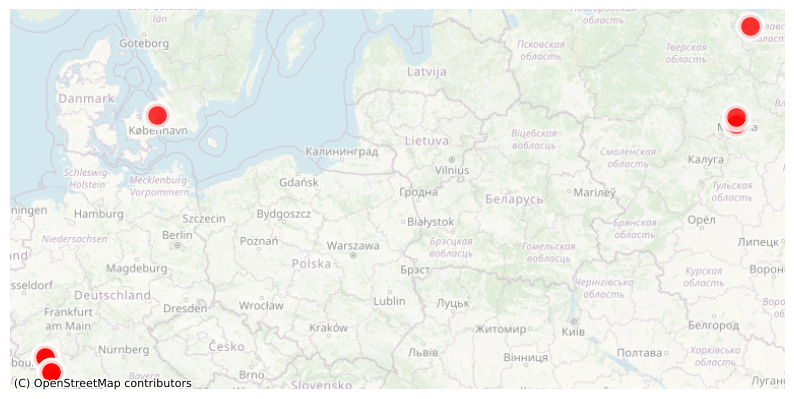

In [26]:
# Create a plot
ax = gdf.plot(
    figsize=(10, 15),
    alpha=0.8,
    linewidth=4,
    edgecolor="white",
    facecolor="red",
    markersize=300)

# Add basemap
cx.add_basemap(
    ax, alpha=0.5,
    source=cx.providers.OpenStreetMap.Mapnik)

# Turn of axes display
ax.set_axis_off()

### Extracting and mapping spatial information for the focus regions (Saxony)

In this example, we map species occurrences in our focus region, Saxony.

To achieve this, we refine our test query into a structured method that loops through the GBIF API and saves the results as a CSV for further processing. However, we must consider the [GBIF Occurrence API documentation](https://techdocs.gbif.org/en/openapi/v1/occurrence#/Searching%20occurrences) limitations:

- Each query can return a maximum of `300` results.
- The total number of results for unauthenticated queries is `100,000`. For larger datasets, the GBIF asynchronous download service is recommended.

Additionally, we apply the following constraints: 
- The query is restricted to Saxony using a geospatial bounding box..
- Results are stored as a CSV, a widely used, accessible, and portable format. However, other formats, such as [Python DataFrame pickles](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_pickle.html), can also be used.

**Defining the spatial parameter**

Before running the query, we must define the spatial parameter to restrict results to Saxony. The [GBIF Occurrence API](https://techdocs.gbif.org/en/openapi/v1/occurrence#/Searching%20occurrences/searchOccurrence) provides a `geometry` parameter that accepts a Well-Known Text (WKT) geometry format. To create a bounding box, we use a pre-defined method stored in `py/modules/tools.py`, which downloads and extracts the latest [VG2500 administrative boundaries ](https://gdz.bkg.bund.de/index.php/default/verwaltungsgebiete-1-2-500-000-stand-31-12-vg2500-12-31.html) from the German Federal Agency for Cartography and Geodesy ([BKG](https://daten.gdz.bkg.bund.de/produkte/vg/vg2500/aktuell/)).

**Loading the geometry**

In [27]:
WORK_DIR = Path.cwd().parents[0] / "tmp"    # Define working directory
WORK_DIR.mkdir(exist_ok=True)               # Create directory if it doesn't exist

# Load world countries' geometry and extract Saxony
de_shapes = tools.get_shapes(
    "de", shape_dir=WORK_DIR / "shapes")   
de_shapes.to_crs(CRS_PROJ, inplace=True)    
sachsen = de_shapes[                        
    de_shapes.index == FOCUS_STATE]         # Saxony

Already exists


**Visualizing the geometry**

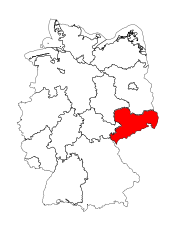

In [28]:
plt_kwags = {
    "color": 'none',
    "edgecolor": 'black',
    "linewidth": 0.2,
    "figsize": (2, 4),
}
ax = de_shapes.plot(**plt_kwags)
plt_kwags["color"] = "red"
ax = sachsen.plot(ax=ax, **plt_kwags)
ax.set_axis_off()

**Projecting and saving the shapefile**

The shapefile is projected to `EPSG:3035` and saved for later use:

In [29]:
OUTPUT = base_path / "out"
sachsen_proj = sachsen.to_crs("epsg:3035")
sachsen_proj.to_file(OUTPUT / 'saxony.gpkg')

**Extracting the bounding box**

To define the bounding box for API queries:
1. Convert the shape to WGS 1984 (`epsg:4326`), as the API requires coordinates in Decimal Degrees.
2. Use the [`.bounds` property of the GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html) to get the bounding box.
3. Retrieve coordinates using [`.values`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.values.html).
4. Apply [`.squeeze()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.squeeze.html#pandas.DataFrame.squeeze) to simplify access to the four bounding box corners. 
   
(content:references:glue-example)=

In [30]:
bbox_sachsen = sachsen.to_crs("epsg:4326").bounds.values.squeeze()
minx, miny = bbox_sachsen[0], bbox_sachsen[1]
maxx, maxy = bbox_sachsen[2], bbox_sachsen[3]

In [31]:
from myst_nb import glue
bounds_before = sachsen.to_crs("epsg:4326").bounds.values
glue("bounds_before", Markdown(
    f"""
    {bounds_before}
    """))
bounds_after = bbox_sachsen
glue("bounds_after", Markdown(
    f"""
     {bounds_after}
    """))


    [[11.87230817 50.17154199 15.03774334 51.6831409 ]]
    


     [11.87230817 50.17154199 15.03774334 51.6831409 ]
    

````{admonition} Inspecting the bounding box
:class: dropdown, tip
Using Jupyter, we can inspect transformations:

This are `sachsen.bounds.values` before using `.squeeze()`:

```{glue:md} bounds_before
:format: myst
```

.. and this is the result after using `squeeze()`:

```{glue:md} bounds_after
:format: myst
```

````

**Converting bounding box to WKT**

The bounding box is converted into a Well-Known Text (WKT) polygon with four corners. According to the GBIF API documentation, the polygon must be ordered in a specific way:

> Polygons must have anticlockwise ordering of points. (A clockwise polygon represents the opposite area: the Earth's surface with a 'hole' in it. Such queries are not supported.)

In [32]:
polygon = Polygon([
    (minx, miny),  # Bottom-left
    (minx, maxy),  # Top-left
    (maxx, maxy),  # Top-right
    (maxx, miny),  # Bottom-right
    (minx, miny)   # Close the polygon
])

# Convert the polygon to WKT format
polygon_ordered = shapely.geometry.polygon.orient(Polygon(polygon), 1.0)
polygon_wkt = dumps(polygon_ordered)

print("Polygon WKT:", polygon_wkt)

Polygon WKT: POLYGON ((11.8723081681852403 50.1715419912565537, 15.0377433372033398 50.1715419912565537, 15.0377433372033398 51.6831409000992821, 11.8723081681852403 51.6831409000992821, 11.8723081681852403 50.1715419912565537))


````{admonition} Simpler ways to generate Well-Known Text (WKT)
:class: dropdown, tip
There are simpler ways to create the Well-Known Text (WKT)
- [GeoDataFrame.to_wkt()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_wkt.html).
- Look up the bounding box for Saxony using tools like [bboxfinder.com](http://bboxfinder.com/#50.324633,12.101440,51.237875,15.295715).
- We could also have used the original shape of Saxony instead of its bounding box. However, complex polygons increase query time, which is why we did not use the original border of Saxony.

The motivation for calculating the bounding box within the Jupyter Notebook using BKG data is to fully _parametrize_ data retrieval. This makes the Jupyter Notebook easily reusable for other regions. To query a different state, simply set `FOCUS_STATE` to the desired state, and all subsequent steps will adjust automatically.
````

### Querying the GBIF Occurrence API for Saxony

The final step is to write a method to request data in _chunks_ from the API. We start by defining our parameters in a dictionary, including the calculated bounding box.

In [33]:
query_url = "https://api.gbif.org/v1/occurrence/search"
limit = 300
params = {
    "taxon_key": taxon_key,
    "continent": continent,
    "limit": limit,
    "geometry": polygon_wkt,
    "offset": 0,
    }

In [34]:
response = requests.get(
        url=query_url, params=params)
print(response.url)
response.status_code

https://api.gbif.org/v1/occurrence/search?taxon_key=5231190&continent=europe&limit=300&geometry=POLYGON+%28%2811.8723081681852403+50.1715419912565537%2C+15.0377433372033398+50.1715419912565537%2C+15.0377433372033398+51.6831409000992821%2C+11.8723081681852403+51.6831409000992821%2C+11.8723081681852403+50.1715419912565537%29%29&offset=0


200

The generated query can be tested in a browser.

In [35]:
map_url = 'https://www.gbif.org/occurrence/map'
r = requests.Request('GET', map_url, params=params)
pr = r.prepare()

In [36]:
display(Markdown(f"Test the above API query in your browser by clicking on it. You can also preview [the query on a map]({pr.url})."))

Test the above API query in your browser by clicking on it. You can also preview [the query on a map](https://www.gbif.org/occurrence/map?taxon_key=5231190&continent=europe&limit=300&geometry=POLYGON+%28%2811.8723081681852403+50.1715419912565537%2C+15.0377433372033398+50.1715419912565537%2C+15.0377433372033398+51.6831409000992821%2C+11.8723081681852403+51.6831409000992821%2C+11.8723081681852403+50.1715419912565537%29%29&offset=0).

**Defining a query function**

In [37]:
def query_gbif_occurrences(query_url, params):
    """Perform an API call and attach results to dataframe
    
    Steps:
    1. Request occurrences
    2. Raise an error for bad responses
    3. Parse the JSON response
    4. Convert API response to a DataFrame
    5. Show progress
    """
    response = requests.get(
        url=query_url, params=params)               # 1.
    response.raise_for_status()                     # 2.
    data = response.json()                          # 3.
    df = pd.DataFrame.from_dict(data['results'])    # 4.
    clear_output(wait=True)                         # 5.
    display(HTML(
            f"Queried {params.get('offset')} occurrences, "
            f"<a href='{response.url}'>last query-url</a>."))
    return df, data['endOfRecords']

**Running the query**

Start the query. Since the API has an upper limit of 100,000 occurrences, we iterate in chunks.

In [38]:
%%time
from IPython.display import clear_output, HTML

df = pd.DataFrame()
status = 200

base_path = Path.cwd().parents[0] # one level up from notebooks/ folder
OUTPUT = base_path / "out"
cache_file = OUTPUT / "occurrences_query.csv"

for ix in range(int(100000/limit)):
    if cache_file.exists():
        # do not query again if already queried;
        # load cache instead; 
        # infer data types by loading all data at once (low_memory=False)
        df = pd.read_csv(cache_file, low_memory=False)
        break
    params["offset"] = ix*limit
    new_df, end_of_records = query_gbif_occurrences(
        query_url, params)
    df = pd.concat(
        [df, new_df], axis = 0, ignore_index = True, sort = True)
    if end_of_records:
        # exit when all available occurrences have been retrieved
        break

CPU times: user 285 ms, sys: 44.1 ms, total: 329 ms
Wall time: 328 ms


**Caching results**

Before storing, we rename columns to `lat` (Latitude) and `lng` (Longitude).

:::{tip} Cache results as CSV file. 
This is generally a good idea. This helps both to conserve limited API resources and to develop code faster (since you won't need to repeatedly query results over and over again).
:::

In [39]:
df.rename(
    columns={"decimalLatitude": "lat", "decimalLongitude": "lng"},
    inplace=True)
if not cache_file.exists():
    df.to_csv(cache_file)

In [40]:
df.head()

,Unnamed: 0.1,Unnamed: 0,acceptedScientificName,acceptedTaxonKey,basisOfRecord,behavior,catalogNumber,class,classKey,collectionCode,...,taxonRank,taxonomicStatus,type,verbatimCoordinateSystem,verbatimElevation,verbatimEventDate,verbatimIdentification,verbatimLocality,vernacularName,year
0,0,0,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,256995752,Aves,212,Observations,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/01 09:48,NaN,"01 Dresden-Plauen, Deutschland",NaN,2025.0
1,1,1,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,256995753,Aves,212,Observations,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/01 09:48,NaN,"01 Dresden-Plauen, Deutschland",NaN,2025.0
2,2,2,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,257355151,Aves,212,Observations,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/04 3:12 PM,NaN,"06237 Leuna-Kötschlitz, Germany",NaN,2025.0
3,3,3,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,257355153,Aves,212,Observations,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/04 3:07 PM,NaN,"06237 Leuna-Kötschlitz, Germany",NaN,2025.0
4,4,4,"Passer domesticus (Linnaeus, 1758)",5231190,HUMAN_OBSERVATION,NaN,257355156,Aves,212,Observations,...,SPECIES,ACCEPTED,NaN,NaN,NaN,2025/01/04 2:57 PM,NaN,"06237 Leuna-Kötschlitz, Germany",NaN,2025.0


### Mapping the data

To create a preview map, we keep only latitude (`lat`) and longitude (`lng`).

In [41]:
df = df.filter(items=['lat', 'lng'])
gdf = gp.GeoDataFrame(
    df, geometry=gp.points_from_xy(df.lng, df.lat))

**Displaying the data**

Using [Geoviews](https://github.com/holoviz/geoviews), we visualize occurrences on a map with Esri satellite imagery (`EsriImagery`) as a background.

The first step is to load the `bokeh`-extension, which is the interactive visualization library that is used by Geoviews to create the map.

Next, we create two layers, a point layer `gv.Points()`, and a polygon layer `gv.Polygons()`).

In the last step, we combine these layers, together with a tile background, into an `Overlay`. Think of an Overlay as a dataframe in ESRI. The resulting `gv_layers` includes all data, interaction and style information.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
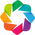

In [42]:
hv.notebook_extension('bokeh')

occurrence_layer = gv.Points(df, kdims=['lng', 'lat'])
sachsen_layer = gv.Polygons(
    sachsen_proj, crs=ccrs.GOOGLE_MERCATOR)

gv_layers = hv.Overlay(
    gv.tile_sources.EsriImagery * \
    sachsen_layer.opts(
        line_color='white',
        line_width=1.0,
        fill_color=None) * \
    occurrence_layer.opts(
        size=3,
        line_color='white',
        line_width=0.1,
        fill_alpha=0.8,
        fill_color='white'))


**Final adjustments**

Before we visualize the Geoviews layer we created above, we apply some further tweaks below:  
- Activate zooming with  the scroll wheel as a default.
- Zoom to Saxony and the data boundaries.
- Ensure the correct projection is used (Web Mercator).
- Add a title to the map.

In [44]:
def set_active_tool(plot, element):
    """Enable wheel_zoom in bokeh plot by default"""
    plot.state.toolbar.active_scroll = plot.state.tools[0]

bbox_sachsen = sachsen.to_crs("epsg:3857").bounds.values.squeeze()
minx, miny = bbox_sachsen[0], bbox_sachsen[1]
maxx, maxy = bbox_sachsen[2], bbox_sachsen[3]

title = f"Species observations of {scientific_name} " \
        f"({SPECIES}) in {FOCUS_STATE}. " \
        f"Number of oberservations: {len(df):,} (date)"

layer_options = {
    "projection": ccrs.GOOGLE_MERCATOR,
    "title": title,
    "responsive": True,        # responsive resize
    "xlim": (minx, maxx),      # limit map boundary to Saxony
    "ylim": (miny, maxy),
    "data_aspect": 1.0,        # maintain fixed aspect ratio
    "hooks": [set_active_tool] # enable zoom on scroll wheel by default
}

In [45]:
gv_layers.opts(**layer_options)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]
   .Points.I   :Points   [lng,lat]

Also, it is possible to save this interactive map as a separate standalone HTML (e.g. for archiving purposes or sharing with others). You can view the final map from this step <a href="/geoviews_map.html" title="View the interactive map">here</a>.

In [40]:
layer_options["data_aspect"] = None
hv.save(
    gv_layers.opts(**layer_options),
    OUTPUT / f'geoviews_map.html', backend='bokeh')

## Dependencies - NEW Notebook in PART 3 References

In Python, "dependencies" typically refer to **packages** and **libraries** that the code needs to function correctly. Packages and libraries are collections of pre-written code that help you to perform various tasks more easily. Each package or library are designed for a specific purpose, such as visualising data.
To run the workflows of this notebook sucessfully, you need to have the required packages or library installed on your computer.

```{dropdown} Not familiar with Python packages or libraries?
The [Python Standard Library Documentation](https://docs.python.org/3/library/index.html) and the lists below provide selected standard library modules as well as third-party packages and libraries.

<details>
<summary><strong>Selected standard library modules (pre-installed with Python)</strong></summary>
    
- [csv](https://docs.python.org/3/library/csv.html):                CSV file reading and writing
- [sys](https://docs.python.org/3/library/sys.html):                System-specific parameters and functions
- [pathlib](https://docs.python.org/3/library/pathlib.html): Object-oriented filesystem paths
- [collections](https://docs.python.org/3/library/collections.html): Container datatypes
- [typing](https://docs.python.org/3/library/typing.html): Support for type hints
- [os](https://docs.python.org/3/library/os.html): Miscellaneous operating system interfaces
      
</details>

<details>
<summary><strong>Selected third-party packages and libaries (require installation)</strong></summary> 
    
- [requests](https://pypi.org/project/requests/): Simplifies making HTTP requests, allowing users to easily send and receive data from web APIs
- [shapely](https://shapely.readthedocs.io/en/latest/manual.html): Geometric operations and spatial queries
- [numpy](https://numpy.org/): Numerical computing and array operations
- [holoviews](https://holoviews.org/): High-level data visualization framework
- [geoviews](https://geoviews.org/): Geographic data visualizations for HoloViews
- [geopandas](https://geopandas.org): Geospatial data manipulation using pandas.
- [pyproj](https://pypi.org/project/pyproj/): Cartographic projections and coordinate transformations library
- [cartopy](https://github.com/SciTools/cartopy): Drawing maps for data analysis and visualisation
- [bokeh](https://github.com/bokeh/bokeh): Interactive web-based visualizations with JavaScript integration.
- [matplotlib](https://matplotlib.org/): Plotting and data visualization library
- [ggplot2](https://ggplot2.tidyverse.org/): System for declaratively creating graphics
  
</details>

`````

```{admonition} Tip: Choosing the right Python package
:class: dropdown, tip
Finding the right Python packages can be daunting. Before getting started, it's helpful to review available libraries and compare alternatives.

**Example**: 
For RESTful APIs, the go-to package in Python is the `requests` library. We have already used this library in the [previous section](201_example_introduction). However, for WCS queries in Python, it's important to explore available alternatives. For example, a quick web search may lead us to [GemGIS](https://gemgis.readthedocs.io/), a package that provides a routine for querying WCS. Looking at its [documentation](https://gemgis.readthedocs.io/en/stable/getting_started/tutorial/21_working_with_web_coverage_services.html), we see that GemGIS relies on [OWSLib](https://github.com/geopython/OWSLib). With OWSLib we can query WCS directly in a Jupyter notebook. Web searches can also reveal useful examples, such as the  [ISIRC SoilGrids notebooks](https://www.isric.org/web-coverage-services-wcs) or the [NASAMAAP documentation](https://docs.maap-project.org/en/stable/technical_tutorials/access/edav_wcs_data.html).
```

Before using a package or library, you must first install it (if it’s not already installed) and then import it at the beginning of your code. This follows a common Python convention, keeping the main logic separate from setup and  “boilerplate” code. 

Check how we structured and loaded dependencies:

In [31]:
# Add an example 